In [17]:
import pandas as pd
import numpy as np
import pcdl
from scipy.stats import ecdf, ks_2samp, wasserstein_distance  # Kolmogorov-Smirnov test

import matplotlib.pyplot as plt
import seaborn as sns

def cell_positions(outputPath):
    mcds = pcdl.TimeStep(xmlfile="final.xml",output_path=outputPath,settingxml=None,microenv=False,graph=False,verbose=False)
    df_cell = mcds.get_cell_df() 
    df_tumor_live = df_cell[ (df_cell['cell_type'] == 'tumor') & (df_cell['dead'] == False) ]
    df_tumor_dead = df_cell[ (df_cell['cell_type'] == 'tumor') & (df_cell['dead'] == True) ]
    df_motile_live = df_cell[ (df_cell['cell_type'] == 'motile_tumor') & (df_cell['dead'] == False) ]
    df_motile_dead = df_cell[ (df_cell['cell_type'] == 'motile_tumor') & (df_cell['dead'] == True) ]
    # distance from the center (0,0,0)
    distances_tumor_live = np.sqrt( (df_tumor_live['position_x'])**2 + (df_tumor_live['position_y'])**2 + (df_tumor_live['position_z'])**2 )
    distances_tumor_dead = np.sqrt( (df_tumor_dead['position_x'])**2 + (df_tumor_dead['position_y'])**2 + (df_tumor_dead['position_z'])**2 )
    distances_motile_live = np.sqrt( (df_motile_live['position_x'])**2 + (df_motile_live['position_y'])**2 + (df_motile_live['position_z'])**2 )
    distances_motile_dead = np.sqrt( (df_motile_dead['position_x'])**2 + (df_motile_dead['position_y'])**2 + (df_motile_dead['position_z'])**2 )
    return distances_tumor_live, distances_tumor_dead, distances_motile_live, distances_motile_dead

def cell_pops(outputPath):
    mcds_ts = pcdl.TimeSeries(output_path=outputPath,settingxml=None,microenv=False,graph=False,verbose=False)
    time = []; tumor_live = []; tumor_dead = []; motile_live = []; motile_dead = []
    for mcds in mcds_ts.get_mcds_list():
        df_cell = mcds.get_cell_df()
        time.append(mcds.get_time())
        df_tumor_live = df_cell[ (df_cell['cell_type'] == 'tumor') & (df_cell['dead'] == False) ]
        df_tumor_dead = df_cell[ (df_cell['cell_type'] == 'tumor') & (df_cell['dead'] == True) ]
        df_motile_live = df_cell[ (df_cell['cell_type'] == 'motile_tumor') & (df_cell['dead'] == False) ]
        df_motile_dead = df_cell[ (df_cell['cell_type'] == 'motile_tumor') & (df_cell['dead'] == True) ]
        tumor_live.append(len(df_tumor_live))
        tumor_dead.append(len(df_tumor_dead))
        motile_live.append(len(df_motile_live))
        motile_dead.append(len(df_motile_dead))
    return time, tumor_live, tumor_dead, motile_live, motile_dead

dist_tumor_live, dist_tumor_dead, dist_motile_live, dist_motile_dead = cell_positions("../outputs/example1_hypoxia")
time , tumor_live, tumor_dead, motile_live, motile_dead = cell_pops("../outputs/example1_hypoxia")


Warning @ pyMCDS._read_xml : physiboss file missing ../outputs/example1_hypoxia/states_final.csv.
Warning @ pyMCDS._read_xml : physiboss file missing ../outputs/example1_hypoxia/states_00000000.csv.
Warning @ pyMCDS._read_xml : physiboss file missing ../outputs/example1_hypoxia/states_00000001.csv.
Warning @ pyMCDS._read_xml : physiboss file missing ../outputs/example1_hypoxia/states_00000002.csv.
Warning @ pyMCDS._read_xml : physiboss file missing ../outputs/example1_hypoxia/states_00000003.csv.
Warning @ pyMCDS._read_xml : physiboss file missing ../outputs/example1_hypoxia/states_00000004.csv.
Warning @ pyMCDS._read_xml : physiboss file missing ../outputs/example1_hypoxia/states_00000005.csv.
Warning @ pyMCDS._read_xml : physiboss file missing ../outputs/example1_hypoxia/states_00000006.csv.
Warning @ pyMCDS._read_xml : physiboss file missing ../outputs/example1_hypoxia/states_00000007.csv.
Warning @ pyMCDS._read_xml : physiboss file missing ../outputs/example1_hypoxia/states_0000000

# Cell population - AUC

The area under the curve (AUC) of cell population over time provides insights into the dynamics of different cell types in the simulation. The AUC is calculated for each cell type (live and dead) to quantify their population changes throughout the experiment.

- **Tumor Live Cells**: The AUC for tumor live cells represents the total number of live tumor cells over time. This metric helps in understanding the growth and survival rate of tumor cells.
- **Motile Live Cells**: The AUC for motile live cells indicates the population dynamics of motile tumor cells, which are typically more invasive and can migrate.
- **Tumor Dead Cells**: The AUC for tumor dead cells shows the cumulative number of dead tumor cells, providing insights into the cell death rate.
- **Motile Dead Cells**: The AUC for motile dead cells reflects the death rate of motile tumor cells.

These AUC values are visualized using a stacked area plot, where each cell type's population is plotted over time, allowing for a clear comparison of their dynamics.

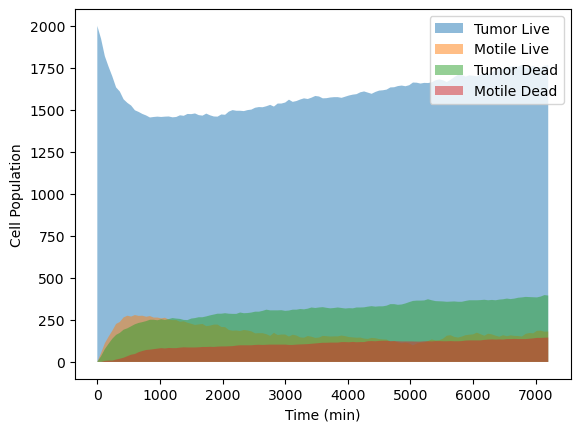

In [18]:
# Plotting AUC
fig, ax = plt.subplots()
ax.fill_between(time, tumor_live, 0, alpha=0.5, label='Tumor Live')
ax.fill_between(time, motile_live, 0, alpha=0.5, label='Motile Live')
ax.fill_between(time, tumor_dead, 0, alpha=0.5, label='Tumor Dead')
ax.fill_between(time, motile_dead, 0, alpha=0.5, label='Motile Dead')
ax.set(xlabel='Time (min)', ylabel='Cell Population')
ax.legend()

# Cell Invasion - distance from the center (last snapshot)

## Distance from the Computational Center and Invasion Analysis

The distance from the computational center (0,0,0) for each cell type provides insights into the spatial distribution and invasion characteristics of the cells. This analysis helps in understanding the extent of cell migration and invasion in the simulated environment.

### Cell Types and Distances
- **Tumor Live Cells**: The distances of live tumor cells from the center indicate their spread and potential invasion into surrounding tissues.
- **Tumor Dead Cells**: The distances of dead tumor cells help in understanding the regions where cell death is more prevalent.
- **Motile Live Cells**: The distances of live motile tumor cells are crucial as these cells are typically more invasive and capable of migrating further from the center.
- **Motile Dead Cells**: The distances of dead motile tumor cells provide insights into the regions where these invasive cells are more likely to die.

### Invasion Analysis
To investigate the invasion characteristics, we use two statistical tests:
- **Kolmogorov-Smirnov Test**: This test compares the empirical cumulative distribution functions (CDFs) of two samples to determine if they are from the same distribution. The maximum distance between the two CDFs indicates the extent of difference between the distributions.
- **Wasserstein Distance**: This metric measures the distance between two probability distributions. It provides a quantitative measure of the difference in spatial distribution between two cell types.


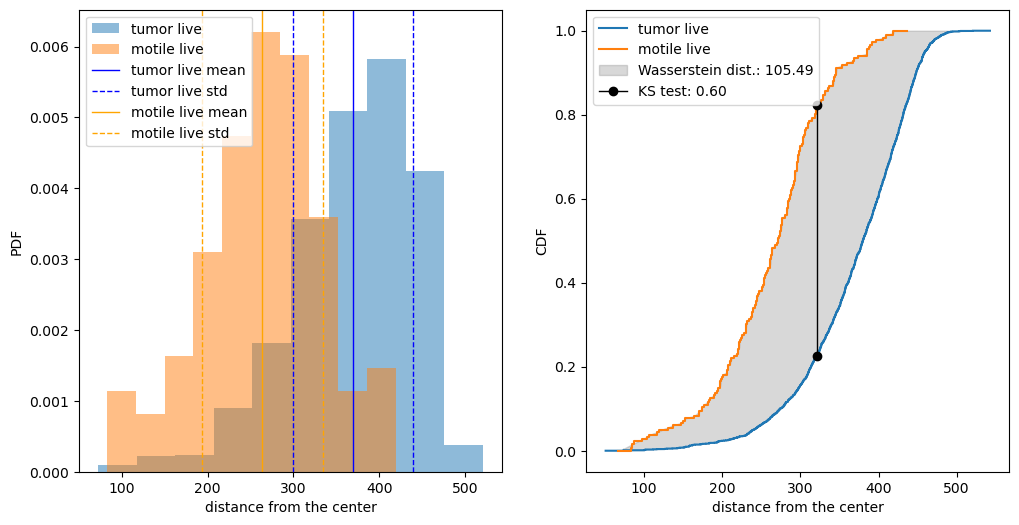

In [19]:
# Define empirical distributions of live cells
emp_liveTumor_cdf = ecdf(dist_tumor_live)
emp_liveMotile_cdf = ecdf(dist_motile_live)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# plot pdf approximations and means
dist_tumor_live.plot(kind='hist', bins=10, density=True, alpha=0.5, ax=ax1, legend=True, label='tumor live')
dist_motile_live.plot(kind='hist', bins=10, density=True, alpha=0.5, ax=ax1, legend=True, label='motile live')
ax1.axvline(dist_tumor_live.mean(), color='blue', linestyle='solid', linewidth=1, label='tumor live mean')
ax1.axvline(dist_tumor_live.mean()+dist_tumor_live.std(), color='blue', linestyle='dashed', linewidth=1, label='tumor live std')
ax1.axvline(dist_tumor_live.mean()-dist_tumor_live.std(), color='blue', linestyle='dashed', linewidth=1)
ax1.axvline(dist_motile_live.mean(), color='orange', linestyle='solid', linewidth=1, label='motile live mean')
ax1.axvline(dist_motile_live.mean()+dist_motile_live.std(), color='orange', linestyle='dashed', linewidth=1, label='motile live std')
ax1.axvline(dist_motile_live.mean()-dist_motile_live.std(), color='orange', linestyle='dashed', linewidth=1)
ax1_set = ax1.set(xlabel='distance from the center', ylabel='PDF')
ax1.legend()

# plot empirical cdf 
emp_liveTumor_cdf.cdf.plot(ax=ax2, label='tumor live')
emp_liveMotile_cdf.cdf.plot(ax=ax2, label='motile live')
# plot the area between CDFs - Wasserstein distance
# interpolate emp_liveMotile_cdf to match the length of emp_liveTumor_cdf
interp_probabilities = np.interp(emp_liveTumor_cdf.cdf.quantiles, emp_liveMotile_cdf.cdf.quantiles, emp_liveMotile_cdf.cdf.probabilities)
wassersteinDistance = wasserstein_distance(emp_liveTumor_cdf.cdf.quantiles, emp_liveMotile_cdf.cdf.quantiles, emp_liveTumor_cdf.cdf.probabilities, emp_liveMotile_cdf.cdf.probabilities)
ax2.fill_between(emp_liveTumor_cdf.cdf.quantiles, emp_liveTumor_cdf.cdf.probabilities, interp_probabilities, alpha=0.3, interpolate=True,color='gray', label=f'Wasserstein dist.: {wassersteinDistance:.2f}')
# plot the maximum distance between the two CDFs - Kolmogorov-sminorf test
max_distance = np.max(np.abs(emp_liveTumor_cdf.cdf.probabilities - interp_probabilities))
max_distance_index = np.argmax(np.abs(emp_liveTumor_cdf.cdf.probabilities - interp_probabilities))
ax2.plot([emp_liveTumor_cdf.cdf.quantiles[max_distance_index]]*2, 
         [emp_liveTumor_cdf.cdf.probabilities[max_distance_index], interp_probabilities[max_distance_index]], 
         color='black', linestyle='-', linewidth=1,marker='o', label=f'KS test: {max_distance:.2f}')

ax2_set = ax2.set(xlabel='distance from the center', ylabel='CDF')
ax2.legend()

plt.show()